In [1]:
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from segmentflow import segment, view
from skimage import morphology, transform, util
%load_ext autoreload
%autoreload 2

1620
Loading images...
--> Images loaded as 3D array:  (600, 1850, 1850)
--> Plotting images: [  0 149 299 449 599]


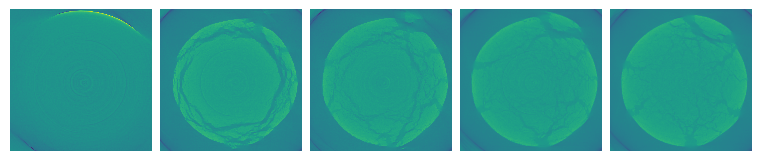

In [6]:
# img_dir = Path(r'..\data\IP_01-he6_raw')
img_dir = Path(r'..\data\IDOX_Estane_test1\IDOX_Estane_test1_Load7')
file_suffix = '.tif'
print(len([p for p in img_dir.glob(f'*{file_suffix}')]))
slices = [100, 700]
# slices = [701, 1550]
scale = 0.5
imgs = segment.load_images(
    img_dir,
    slice_crop=slices,
    row_crop=[0, 1850],
    col_crop=[0, 1850],
    file_suffix=file_suffix
)
fig, axes = view.vol_slices(imgs, nslices=5)
plt.show()

In [ ]:
# img_dir = Path(r'..\data\IP_01-he6_raw')
img_dir = Path(r'..\data\IDOX_Estane_test1\IDOX_Estane_test1_Load1')
file_suffix = '.tif'
print(len([p for p in img_dir.glob(f'*{file_suffix}')]))
# slices = [100, 700]
slices = [701, 1550]
scale = 0.5
imgs = segment.load_images(
    img_dir,
    slice_crop=slices,
    row_crop=[200, 1700],
    col_crop=[200, 1700],
    file_suffix=file_suffix
)
fig, axes = view.vol_slices(imgs, nslices=5)
plt.show()

In [ ]:
# imgs = transform.rescale(imgs, 0.1, anti_aliasing=True)
imgs = transform.rescale(imgs, scale, anti_aliasing=False)
print('Images downsized:', imgs.shape)
fig, axes = view.vol_slices(imgs, nslices=5)
plt.show()

In [ ]:
# Plot intensity rescale histogram
imgs = segment.preprocess(
    imgs, median_filter=True,
    rescale_intensity_range=[0.01, 99.99])
imgs = util.img_as_uint(imgs)
fig, axes = view.vol_slices(imgs, nslices=5)
plt.show()

In [ ]:
# Calc semantic seg threshold values and generate histogram
thresholds, fig, ax = segment.threshold_multi_otsu(
    imgs, nclasses=2, nbins=256, return_fig_ax=True, convert_to_float=False
)
plt.show()

In [ ]:
imgs = segment.isolate_classes(imgs, thresholds)
fig, axes = view.vol_slices(imgs, nslices=5)
plt.show()

In [ ]:
imgs_shell = imgs - morphology.binary_erosion(imgs)
fig, axes = view.vol_slices(imgs_shell, nslices=5)
plt.show()

In [ ]:
# fig, axes = view.vol_slices(imgs_shell[:, 700:800, 0:100], nslices=5)
# fig, axes = view.vol_slices(imgs_shell[:, 300:400, 300:400], nslices=5)
# plt.show()

In [ ]:
shell_verts = np.argwhere(imgs_shell == 1)
shell_df = pd.DataFrame(shell_verts, columns=['slice', 'row', 'column'])
shell_df['slice'] = shell_df['slice'] + 300
print('Total n voxels:', math.prod(i for i in imgs.shape))
print('Shell n vertices:', shell_df.index.shape[0])
shell_df.to_csv(
    f'../results/{img_dir.name[:]}/{img_dir.name}_shell_{scale}scale'
    f'_{str(slices[0]).zfill(4)}-{str(slices[1]).zfill(4)}.csv',
    index=False
)
shell_df.head()

In [2]:
def save_shell_vertices(
        img_dir_path,
        save_dir_path,
        slice_crop=None,
        row_crop=None,
        col_crop=None,
        slice_offset=0,
        scale=1,
        file_suffix='.tif'
    ):
    img_dir_path = Path(img_dir_path)
    save_dir_path = Path(save_dir_path)
    save_path = (
        save_dir_path / f'{img_dir_path.name[:]}'
        f'/{img_dir_path.name}_shell_{scale}scale_slices-'
        f'{str(slice_crop[0]).zfill(4)}-{str(slice_crop[1]).zfill(4)}.csv'
    )
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True)
    imgs = segment.load_images(
        img_dir_path,
        slice_crop=slice_crop,
        row_crop=row_crop,
        col_crop=col_crop,
        file_suffix=file_suffix
    )
    # Downscale iamges
    if scale != 1:
        print('Downsizing images...')
        imgs = transform.rescale(imgs, scale, anti_aliasing=False)
        print('--> Images downsized:', imgs.shape)
    # Plot intensity rescale histogram
    imgs = segment.preprocess(
        imgs, median_filter=True,
        rescale_intensity_range=[0.01, 99.99])
    imgs = util.img_as_uint(imgs)
    # Calc semantic seg threshold values and generate histogram
    thresholds = segment.threshold_multi_otsu(
        imgs, nclasses=2, nbins=256, convert_to_float=False
    )
    # Segment images
    imgs = segment.isolate_classes(imgs, thresholds)
    # Create shell
    imgs_shell = imgs - morphology.binary_erosion(imgs)
    shell_verts = np.argwhere(imgs_shell == 1)
    shell_df = pd.DataFrame(shell_verts, columns=['slice', 'row', 'column'])
    shell_df['slice'] = shell_df['slice'] + slice_offset
    shell_df['row'] = shell_df['row'] + int(round(row_crop[0] * scale))
    shell_df['column'] = shell_df['column'] + int(round(col_crop[0] * scale))
    print('Total n voxels:', math.prod(i for i in imgs.shape))
    print('Shell n vertices:', shell_df.index.shape[0])
    save_path = (
        save_dir_path / f'{img_dir_path.name[:]}'
        f'/{img_dir_path.name}_shell_{scale}scale_slices-'
        f'{str(slice_crop[0]).zfill(4)}-{str(slice_crop[1]).zfill(4)}.csv'
    )
    shell_df.to_csv(save_path, index=False)
    if save_path.exists():
        print(f'Shell vertices saved to CSV: {save_path}')

In [3]:
img_dir = Path(r'..\data\IDOX_Estane_test1\IDOX_Estane_test1_Load7')
save_dir = Path(r'../results')
slice_crops = [[100, 700], [701, 1550]]
offsets = [0, 300]
for slice_crop, offset in zip(slice_crops, offsets):
    save_shell_vertices(
        img_dir,
        save_dir,
        slice_crop=slice_crop,
        # slice_crop=[100, 700],
        # slice_crop=[701, 1550],
        row_crop=[0, 1850],
        col_crop=[0, 1850],
        slice_offset=offset,
        scale=0.5,
        file_suffix='.tif'
    )

Loading images...
--> Images loaded as 3D array:  (600, 1850, 1850)
Downsizing images...
--> Images downsized: (300, 925, 925)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0.01, 99.99]...
--> Preprocessing complete.
Calculating Multi Otsu thresholds...
Total n voxels: 256687500
Shell n vertices: 2664083
Shell vertices saved to CSV: ..\results\IDOX_Estane_test1_Load7\IDOX_Estane_test1_Load7_shell_0.5scale_slices-0100-0700.csv
Loading images...
--> Images loaded as 3D array:  (849, 1850, 1850)
Downsizing images...
--> Images downsized: (424, 925, 925)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0.01, 99.99]...
--> Preprocessing complete.
Calculating Multi Otsu thresholds...
Total n voxels: 362785000
Shell n vertices: 3457219
Shell vertices saved to CSV: ..\results\IDOX_Estane_test1_Load7\IDOX_Estane_test1_Load7_shell_0.5scale_slices-0701-1550.csv


In [4]:
load_n = 7
csv_path = (
    fr'..\results\IDOX_Estane_test1_Load{load_n}'
    fr'\IDOX_Estane_test1_Load{load_n}_shell_0.5scale_slices-0100-0700.csv'
    # fr'\IDOX_Estane_test1_Load{load_n}_shell_0.5scale_slices-0701-1550.csv'
)
df = pd.read_csv(csv_path)
print('Slices')
print('------')
print(df['slice'].min())
print(df['slice'].max())
print('Rows')
print('----')
print(df['row'].min())
print(df['row'].max())
print('Cols')
print('----')
print(df['column'].min())
print(df['column'].max())

Slices
------
0
299
Rows
----
0
920
Cols
----
0
924


In [ ]:
df.to_csv(csv_path, index=False)

In [ ]:
round(10.5)